# PCA and k-means

## Setting up

In [2]:
"""
Author      : Yi-Chieh Wu, Sriram Sankararaman
"""
import time

# numpy and scipy libraries
import numpy as np
from scipy import stats

# matplotlib libraries
import matplotlib.pyplot as plt
import collections

In [3]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
# Change the path below to the path where your folder locates
# where you have util.py
### ==================== ###
sys.path.append('/content/drive/My Drive/PS4')
### ==================== ###


In [5]:
import util
from util import *

## Point, Cluster and Set of Clusters classes

In [6]:
######################################################################
# classes
######################################################################

class Point(object) :

    def __init__(self, name, label, attrs) :
        """
        A data point.

        Attributes
        --------------------
            name  -- string, name
            label -- string, label
            attrs -- numpy arrray of shape (d, ) where d is the number of features
        """

        self.name = name
        self.label = label
        self.attrs = attrs


    #============================================================
    # utilities
    #============================================================

    def distance(self, other) :
        """
        Return Euclidean distance of this point with other point.

        Parameters
        --------------------
            other -- Point, point to which we are measuring distance

        Returns
        --------------------
            dist  -- float, Euclidean distance
        """
        # Euclidean distance metric
        return np.linalg.norm(self.attrs-other.attrs)


    def __str__(self) :
        """
        Return string representation.
        """
        return "%s : (%s, %s)" % (self.name, str(self.attrs), self.label)

In [31]:
class Cluster(object) :

    def __init__(self, points) :
        """
        A cluster (set of points).

        Attributes
        --------------------
            points -- list of Points, cluster elements
        """
        self.points = points


    def __str__(self) :
        """
        Return string representation.
        """
        s = ""
        for point in self.points :
            s += str(point)
        return s

    #============================================================
    # utilities
    #============================================================

    def purity(self) :
        """
        Compute cluster purity.

        Returns
        --------------------
            n           -- int, number of points in this cluster
            num_correct -- int, number of points in this cluster
                                with label equal to most common label in cluster
        """
        labels = []
        for p in self.points :
            labels.append(p.label)

        cluster_label, count = stats.mode(labels)
        return len(labels), np.float64(count)


    def centroid(self) :
        """
        Compute centroid of this cluster.

        Returns
        --------------------
            centroid -- Point, centroid of cluster
        """

        ### ==================== ###
        # part 2b: implement
        # set the centroid label to any value (e.g. the most common label in this cluster)
        centroid = Point("Centroid", label=None, attrs=None)
        centroid.attrs = sum([p.attrs for p in self.points])/len(self.points)
        centroid.label = stats.mode([p.label for p in self.points])
        return centroid
        ### ==================== ###



    def medoid(self) :
        """
        Compute medoid of this cluster, that is, the point in this cluster
        that is closest to all other points in this cluster.

        Returns
        --------------------
            medoid -- Point, medoid of this cluster
        """

        ### ==================== ###
        # part 2b: implement

        dists = {p:0 for p in self.points}
        for point1 in self.points:
          for point2 in self.points:
            dists[point1] += point1.distance(point2)
        d = sorted(dists.items(), key = lambda x: x[1])
        return d[0][0]
        ### ==================== ###


    def equivalent(self, other) :
        """
        Determine whether this cluster is equivalent to other cluster.
        Two clusters are equivalent if they contain the same set of points
        (not the same actual Point objects but the same geometric locations).

        Parameters
        --------------------
            other -- Cluster, cluster to which we are comparing this cluster

        Returns
        --------------------
            flag  -- bool, True if both clusters are equivalent or False otherwise
        """

        if len(self.points) != len(other.points) :
            return False

        matched = []
        for point1 in self.points :
            for point2 in other.points :
                if point1.distance(point2) == 0 and point2 not in matched :
                    matched.append(point2)
        return len(matched) == len(self.points)

In [54]:
class ClusterSet(object):

    def __init__(self) :
        """
        A cluster set (set of clusters).

        Parameters
        --------------------
            members -- list of Clusters, clusters that make up this set
        """
        self.members = []


    #============================================================
    # utilities
    #============================================================

    def centroids(self) :
        """
        Return centroids of each cluster in this cluster set.

        Returns
        --------------------
            centroids -- list of Points, centroids of each cluster in this cluster set
        """

        ### ==================== ###
        # part 2b: implement
        centroids = [c.centroid() for c in self.members]
        return centroids

        ### ==================== ###


    def medoids(self) :
        """
        Return medoids of each cluster in this cluster set.

        Returns
        --------------------
            medoids -- list of Points, medoids of each cluster in this cluster set
        """

        ### ==================== ###
        # part 2b: implement
        medoids = [c.medoid() for c in self.members]
        return medoids

        ### ==================== ###


    def score(self) :
        """
        Compute average purity across clusters in this cluster set.

        Returns
        --------------------
            score -- float, average purity
        """

        total_correct = 0
        total = 0
        for c in self.members :
            n, n_correct = c.purity()
            total += n
            total_correct += n_correct
        return total_correct / float(total)


    def equivalent(self, other) :
        """
        Determine whether this cluster set is equivalent to other cluster set.
        Two cluster sets are equivalent if they contain the same set of clusters
        (as computed by Cluster.equivalent(...)).

        Parameters
        --------------------
            other -- ClusterSet, cluster set to which we are comparing this cluster set

        Returns
        --------------------
            flag  -- bool, True if both cluster sets are equivalent or False otherwise
        """

        if len(self.members) != len(other.members):
            return False

        matched = []
        for cluster1 in self.members :
            for cluster2 in other.members :
                if cluster1.equivalent(cluster2) and cluster2 not in matched:
                    matched.append(cluster2)
        return len(matched) == len(self.members)


    #============================================================
    # manipulation
    #============================================================

    def add(self, cluster):
        """
        Add cluster to this cluster set (only if it does not already exist).

        If the cluster is already in this cluster set, raise a ValueError.

        Parameters
        --------------------
            cluster -- Cluster, cluster to add
        """

        if cluster in self.members :
            raise ValueError

        self.members.append(cluster)

## k-means and k-medoids algorithms

In [56]:
######################################################################
# k-means and k-medoids
######################################################################

def random_init(points, k) :
    """
    Randomly select k unique elements from points to be initial cluster centers.

    Parameters
    --------------------
        points         -- list of Points, dataset
        k              -- int, number of clusters

    Returns
    --------------------
        initial_points -- list of k Points, initial cluster centers
    """
    ### ==================== ###
    # part 2c: implement (hint: use np.random.choice)
    initial_points = np.random.choice(a=points,size=k, replace=False)
    return initial_points

    ### ==================== ###


def cheat_init(points) :
    """
    Initialize clusters by cheating!

    Details
    - Let k be number of unique labels in dataset.
    - Group points into k clusters based on label (i.e. class) information.
    - Return medoid of each cluster as initial centers.

    Parameters
    --------------------
        points         -- list of Points, dataset

    Returns
    --------------------
        initial_points -- list of k Points, initial cluster centers
    """
    ### ==================== ###
    # part 2f: implement
    l = list(set([p.label for p in points]))
    clus = {n:[] for n in l}
    for p in points:
      clus[p.label].append(p)

    return [Cluster(c).medoid() for c in clus.values()]

    ### ==================== ###

def kAverages(points, k, average, init='random', plot=False) :
    """
    Cluster points into k clusters using variations of k-means algorithm.

    Parameters
    --------------------
        points  -- list of Points, dataset
        k       -- int, number of clusters
        average -- method of ClusterSet
                   determines how to calculate average of points in cluster
                   allowable: ClusterSet.centroids, ClusterSet.medoids
        init    -- string, method of initialization
                   allowable:
                       'cheat'  -- use cheat_init to initialize clusters
                       'random' -- use random_init to initialize clusters
        plot    -- bool, True to plot clusters with corresponding averages
                         for each iteration of algorithm

    Returns
    --------------------
        k_clusters -- ClusterSet, k clusters
    """
    ### ==================== ###
    # part 2c,2d: implement
    init_cent = random_init(points, k) if init == 'random' else cheat_init(points)
    init_clus = {str(p): [] for p in init_cent}
    for p in points:
      min_dist = float('inf')
      closest_clus = None
      for c in init_cent:
        d = p.distance(c)
        if d < min_dist:
          min_dist = d
          closest_clus = c
      init_clus[str(closest_clus)].append(p)

    clusters = ClusterSet()
    clusters.members = [Cluster(p) for p in init_clus.values() if p]
    i = 1
    while True:
      if plot:
        plot_clusters(clusters, f"Iteration {i}", average)
      aNew = False
      new_clus = {}
      for c in clusters.members:
        for p in c.points:
          min_dist = float('inf')
          closest_clus = None
          for n in clusters.members:
            d = p.distance(n.centroid() if average == ClusterSet.centroids else n.medoid())
            if d < min_dist:
              min_dist = d
              closest_clus = n
          if not c.equivalent(closest_clus):
            aNew = True
          if str(closest_clus) not in new_clus:
            new_clus[str(closest_clus)] = [p]
          else:
            new_clus[str(closest_clus)].append(p)
      clusters.members = [Cluster(p) for p in new_clus.values() if p]
      if not aNew:
        break
      i+=1
    return clusters
    ### ==================== ###


def kMeans(points, k, init='random', plot=False) :
    """
    Cluster points into k clusters using variations of k-means algorithm.

    Parameters
    --------------------
        points  -- list of Points, dataset
        k       -- int, number of clusters
        init    -- string, method of initialization
                   allowable:
                       'cheat'  -- use cheat_init to initialize clusters
                       'random' -- use random_init to initialize clusters
        plot    -- bool, True to plot clusters with corresponding averages
                         for each iteration of algorithm

    Returns
    --------------------
        k_clusters -- ClusterSet, k clusters
    """

    ### ==================== ###
    # part 2c: implement
    # Hints:
    #   (1) On each iteration, keep track of the new cluster assignments
    #       in a separate data structure. Then use these assignments to create
    #       a new ClusterSet object and update the centroids.
    #   (2) Repeat until the clustering no longer changes.
    #   (3) To plot, use plot_clusters(...).
    return kAverages(points, k, ClusterSet.centroids, init, plot)

    ### ==================== ###


def kMedoids(points, k, init='random', plot=False) :
    """
    Cluster points in k clusters using k-medoids clustering.
    See kMeans(...).
    """
    ### ==================== ###
    # part 2e: implement
    return kAverages(points, k, ClusterSet.medoids, init, plot)
    ### ==================== ###


## Utilities

In [43]:
######################################################################
# helper functions
######################################################################

def build_face_image_points(X, y) :
    """
    Translate images to (labeled) points.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), features (each row is one image)
        y     -- numpy array of shape (n,), targets

    Returns
    --------------------
        point -- list of Points, dataset (one point for each image)
    """

    n,d = X.shape

    images = collections.defaultdict(list) # key = class, val = list of images with this class
    for i in range(n) :
        images[y[i]].append(X[i,:])

    points = []
    for face in images :
        count = 0
        for im in images[face] :
            points.append(Point(str(face) + '_' + str(count), face, im))
            count += 1

    return points


def plot_clusters(clusters, title, average) :
    """
    Plot clusters along with average points of each cluster.

    Parameters
    --------------------
        clusters -- ClusterSet, clusters to plot
        title    -- string, plot title
        average  -- method of ClusterSet
                    determines how to calculate average of points in cluster
                    allowable: ClusterSet.centroids, ClusterSet.medoids
    """

    plt.figure()
    np.random.seed(20)
    label = 0
    colors = {}
    centroids = average(clusters)
    for c in centroids :
        coord = c.attrs
        plt.plot(coord[0],coord[1], 'ok', markersize=12)
    for cluster in clusters.members :
        label += 1
        colors[label] = np.random.rand(3,)
        for point in cluster.points :
            coord = point.attrs
            plt.plot(coord[0], coord[1], 'o', color=colors[label])
    plt.title(title)
    plt.show()


def generate_points_2d(N, seed=1234) :
    """
    Generate toy dataset of 3 clusters each with N points.

    Parameters
    --------------------
        N      -- int, number of points to generate per cluster
        seed   -- random seed

    Returns
    --------------------
        points -- list of Points, dataset
    """
    np.random.seed(seed)

    mu = [[0,0.5], [1,1], [2,0.5]]
    sigma = [[0.1,0.1], [0.25,0.25], [0.15,0.15]]

    label = 0
    points = []
    for m,s in zip(mu, sigma) :
        label += 1
        for i in range(N) :
            x = random_sample_2d(m, s)
            points.append(Point(str(label)+'_'+str(i), label, x))

    return points

## Main function

Total dataset size:
	num_samples: 1867
	num_features: 1850
	num_classes: 19


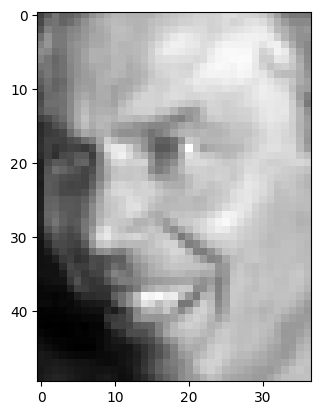

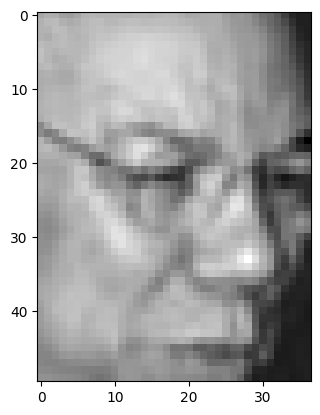

In [70]:
######################################################################
# main
######################################################################

def main() :
    ### ==================== ###

    # part 1: explore LFW data set
    # part a

    ## Use get_lfw_data(...) to get the LFW dataset with labels,
    X, y = get_lfw_data()
    U, mu = PCA(X)
    '''
    show_image(X[0, :])
    show_image(X[1, :])
    show_image(X[2, :])
    mean_image = np.mean(X, axis=0)
    show_image(mean_image)


    # part b
    ## how the top twelve eigenfaces using PCA

    top_eigenfaces = [vec_to_image(U[:, i]) for i in range(12)]
    plot_gallery(top_eigenfaces, title="Top 12 Eigenfaces")

    # part c
    ## compare the original image with the reconstructions
    galleries = []
    l_vals = [1, 10, 50, 100, 500, 1288]
    for l in l_vals:
      #Project images to a lower-dimensional
      Z, Ul = apply_PCA_from_Eig(X, U, l, mu)
      X_rec = reconstruct_from_PCA(Z, U[:, :l], mu)
      images_rec = X_rec[:12, :]
      images_rec = [vec_to_image(images_rec[i, :]) for i in range(images_rec.shape[0])]
      galleries.append(images_rec)

    #Plot galleries for all values of l
    for i, l in enumerate(l_vals):
      plot_gallery(galleries[i], title=f'Reconstructed with {l} components')
    '''

    ### ==================== ###



    ### ==================== ###
    # part 2d-2f: cluster toy dataset
    '''
    pts = generate_points_2d(20)
    kMedoids(pts, 3, plot= True, init = 'cheat')
    kMeans(pts, 3, plot = True, init = 'cheat')
    '''
    ### ==================== ###



    ### ========== TODO : START ========== ###
    # part 3a: cluster faces
    np.random.seed(1234) ## don't change the seed !!
    '''
    X1, y1 = util.limit_pics(X, y, [4, 6, 13, 16], 40)
    points = build_face_image_points(X1, y1)
    means = 0
    medoids = 1
    # Initialize for scores and timing comparison
    algorithm_scores = [[float('inf'), 0, 0], [float('inf'), 0, 0]]  # [kMeans, kMedoids] x [min, max, total]
    algorithm_times = [[float('inf'), 0, 0], [float('inf'), 0, 0]]

    for _ in range(10):
      start_kmeans = time.time()
      results_kmeans = kMeans(points, 4)
      end_kmeans = time.time()

      start_kmedoids = time.time()
      results_kmedoids = kMedoids(points, 4)
      end_kmedoids = time.time()

      kmeans_duration = end_kmeans - start_kmeans
      kmedoids_duration = end_kmedoids - start_kmedoids

      algorithm_scores[0][0], algorithm_scores[1][0] = min(algorithm_scores[0][0], results_kmeans.score()), min(algorithm_scores[1][0], results_kmedoids.score())
      algorithm_scores[0][1], algorithm_scores[1][1] = max(algorithm_scores[0][1], results_kmeans.score()), max(algorithm_scores[1][1], results_kmedoids.score())
      algorithm_scores[0][2] += results_kmeans.score()
      algorithm_scores[1][2] += results_kmedoids.score()

      algorithm_times[0][0], algorithm_times[1][0] = min(algorithm_times[0][0], kmeans_duration), min(algorithm_times[1][0], kmedoids_duration)
      algorithm_times[0][1], algorithm_times[1][1] = max(algorithm_times[0][1], kmeans_duration), max(algorithm_times[1][1], kmedoids_duration)
      algorithm_times[0][2] += kmeans_duration
      algorithm_times[1][2] += kmedoids_duration

    print("Scores:")
    print(f"kMeans: Min: {algorithm_scores[0][0]}, Max: {algorithm_scores[0][1]}, Avg: {algorithm_scores[0][2]/10}")
    print(f"kMedoids: Min: {algorithm_scores[1][0]}, Max: {algorithm_scores[1][1]}, Avg: {algorithm_scores[1][2]/10}")

    print("Times:")
    print(f"kMeans: Min: {algorithm_times[0][0]}, Max: {algorithm_times[0][1]}, Avg: {algorithm_times[0][2]/10}")
    print(f"kMedoids: Min: {algorithm_times[1][0]}, Max: {algorithm_times[1][1]}, Avg: {algorithm_times[1][2]/10}")
    '''


    # part 3b: explore effect of lower-dimensional representations on clustering performance
    '''
    np.random.seed(1234) ## don't change the seed !!
    for num_components in [1, 10, 50, 100, 500, 1288]:
        reduced_data, pca_basis = apply_PCA_from_Eig(X, U, num_components, mu)
        reconstructed_data = reconstruct_from_PCA(reduced_data, pca_basis, mu)
        print("WITH num_components =", num_components)
        plot_gallery(reconstructed_data)

    X_filtered, y_filtered = limit_pics(X, y, [4, 13], 40)
    kmeans_purity_scores = []
    kmedoids_purity_scores = []

    #Iterating over range of PCA components to see their effect on clustering purity
    for num_components in range(1, 50, 2):
        reduced_data, pca_basis = apply_PCA_from_Eig(X_filtered, U, num_components, mu)
        reconstructed_data = reconstruct_from_PCA(reduced_data, pca_basis, mu)
        new_points = build_face_image_points(reconstructed_data, y_filtered)
        cluster_kmeans = kMeans(new_points, 2, init="cheat")
        cluster_kmedoids = kMedoids(new_points, 2, init="cheat")

        kmeans_purity_scores.append(cluster_kmeans.score())
        kmedoids_purity_scores.append(cluster_kmedoids.score())

    # Plotting the comparison of purity scores for k-means and k-medoids across different PCA component counts
    plt.plot(range(1, 50, 2), kmeans_purity_scores, label="k-means")
    plt.plot(range(1, 50, 2), kmedoids_purity_scores, label="k-medoids")
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Clustering Purity Score")
    plt.title("Comparison of Clustering Purity: K-Means vs K-Medoids across PCA Components")
    plt.legend()
    plt.show()

    '''

    # part 3c: determine ``most discriminative'' and ``least discriminative'' pairs of images
    np.random.seed(1234) ## don't change the seed !!
    # Initialize dictionary to hold scores for each pair of classes
    '''
    pairwise_scores = {}

    for class1 in range(19):
        for class2 in range(19):
            if class1 < class2:
                # Restrict dataset to images of the two current classes
                filtered_images, filtered_labels = util.limit_pics(X, y, [class1, class2], 40)

                # Apply PCA to reduce dimensionality
                reduced_data, pca_components = util.apply_PCA_from_Eig(filtered_images, U, 50, mu)

                # Reconstruct images from PCA to use in clustering
                reconstructed_images = util.reconstruct_from_PCA(reduced_data, pca_components, mu)

                # Build points from the reconstructed images
                image_points = build_face_image_points(reconstructed_images, filtered_labels)

                # Perform kMeans clustering with the reduced dataset
                clusters = kMeans(image_points, 2, init='cheat')

                # Calculate and store the clustering score
                clustering_score = clusters.score()
                pairwise_scores[(class1, class2)] = clustering_score

    print("-------------------")
    # Sort the scores to identify the most and least discriminative pairs
    sorted_scores = sorted(pairwise_scores.items(), key=lambda item: item[1])

    print("Most SIMILAR Pairs of Classes")
    print(sorted_scores[:10])
    print("--------------------------------")
    print("Most DISCRIMINATE Pairs of Classes")
    print(sorted_scores[-10:])
    '''
    show_image(X[0, :])
    show_image(X[13, :])
    #show_image(X[0, :])
    #show_image(X[13, :])


    ### ========== TODO : END ========== ###


if __name__ == "__main__" :
    main()